In [1]:
import os
import json
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Audio, display
from tensorflow.keras import layers
import random

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
def audio_to_mfcc(audio_file, n_mfcc=40):
    try:
        # Load audio file
        audio, sr = librosa.load(audio_file, sr=22050)
        # Extract MFCCs and compute mean over time frames
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        return np.mean(mfccs, axis=1)  # Return mean across time axis
    except Exception as e:
        print(f"Error processing {audio_file}: {e}")
        return None

In [3]:
def process_audio_files(directory):
    extracted_features = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('.mp3', '.wav')):
                audio_path = os.path.join(root, file)
                mfcc_features = audio_to_mfcc(audio_path)
                if mfcc_features is not None:
                    target_class = os.path.basename(root)
                    extracted_features.append([mfcc_features, target_class])
    return extracted_features


In [ ]:
directory = 'Voice of Birds/Voice of Birds'
extracted_features = process_audio_files(directory)

In [ ]:
audio_files = []
for root, _, files in os.walk(directory):
    for file in files:
        if file.endswith(('.mp3', '.wav')):  # Include only audio files
            audio_files.append(os.path.join(root, file))

# Ensure there are audio files in the directory
if not audio_files:
    print("No audio files found in the directory.")
else:
    # Choose a random file
    random_file = random.choice(audio_files)

    print(f"Selected File: {random_file}")

    # Load Audio File
    audio_data, sample_rate = librosa.load(path=random_file)

    # Plot the waveform
    plt.figure(figsize=(15, 5))
    librosa.display.waveshow(y=audio_data, sr=sample_rate)
    plt.title(f"Waveform of {os.path.basename(random_file)}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

    # Provide the option to play the audio
    print(f"Playing audio: {os.path.basename(random_file)}")
    display(Audio(data=random_file, autoplay=False))  # Option to play the audio


In [ ]:
audio_files = []
for root, _, files in os.walk(directory):
    for file in files:
        if file.endswith(('.mp3', '.wav')):  # Include only audio files
            audio_files.append(os.path.join(root, file))

# Ensure there are audio files in the directory
if not audio_files:
    print("No audio files found in the directory.")
else:
    # Choose a random file
    random_file = random.choice(audio_files)

    print(f"Selected File: {random_file}")

    # Load Audio File
    try:
        audio_data, sample_rate = librosa.load(path=random_file, sr=None)  # Use original sample rate

        # Plot the waveform
        plt.figure(figsize=(15, 5))
        librosa.display.waveshow(y=audio_data, sr=sample_rate)
        plt.title(f"Waveform of {os.path.basename(random_file)}")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.show()

        # Compute MFCCs
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=13)

        # Get frame times
        frame_times = librosa.frames_to_time(np.arange(mfccs.shape[1]), sr=sample_rate)


        # Plot MFCCs
        plt.figure(figsize=(15, 5))
        librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time', cmap='viridis')
        plt.colorbar(label='MFCC Coefficients')
        plt.title('MFCC')
        plt.xlabel('Time (s)')
        plt.ylabel('MFCC Coefficients')
        plt.show()

        # Provide the option to play the audio
        print(f"\nPlaying audio: {os.path.basename(random_file)}")
        display(Audio(data=random_file, autoplay=False))

    except Exception as e:
        print(f"Error loading or processing the file: {e}")


In [ ]:
features_df = pd.DataFrame(extracted_features, columns=['features', 'class'])

In [10]:
target_encoder = LabelEncoder()
features_df['target'] = target_encoder.fit_transform(features_df['class'])

In [ ]:
prediction_dict = features_df.set_index('target')['class'].to_dict()
prediction_dict

In [13]:
# Convert the keys of the prediction_dict to strings
prediction_dict = {str(key): value for key, value in prediction_dict.items()}

# Saving the class to target mapping to JSON
with open('prediction.json', 'w') as f:
    json.dump(prediction_dict, f, indent=4)

In [14]:
features = np.array([np.pad(f[0], (0, max(0, 40 - len(f[0]))), mode='constant')[:40] for f in extracted_features])
labels = np.array(features_df['target'].tolist())

In [15]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


In [16]:
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)

In [17]:
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.int32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.int32)

In [18]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32).shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32).prefetch(tf.data.AUTOTUNE)

(40,)

(32,)



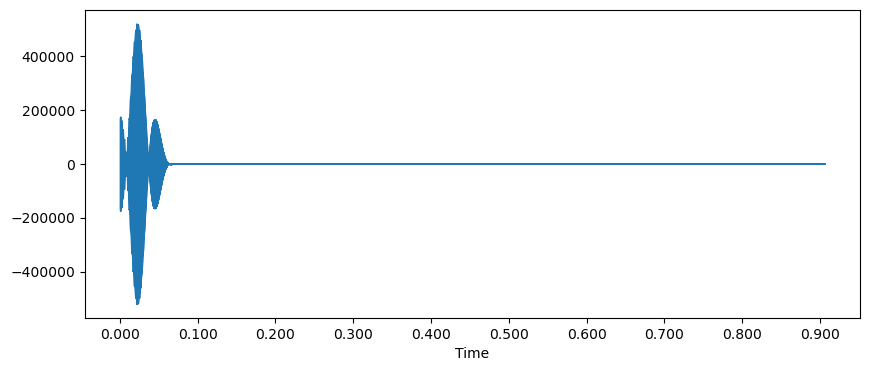

In [19]:
for audio_batch, label_batch in train_ds.take(1):
    print(audio_batch.numpy()[0].shape)
    print()

    print(label_batch.numpy().shape)
    print()

    audio = librosa.feature.inverse.mfcc_to_audio(audio_batch.numpy())

    # Plot the reconstructed audio waveform
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio)
    plt.show()

In [20]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam

model = models.Sequential([
    layers.Input(shape=(40, 1)),
    
    # Convolutional layers
    layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool1D(pool_size=2, padding='same'),
    
    layers.Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool1D(pool_size=2, padding='same'),
    
    layers.Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool1D(pool_size=2, padding='same'),
    
    # Global Average Pooling instead of Flatten
    layers.GlobalAveragePooling1D(),
    
    # Dense layers with more advanced regularization
    layers.Dense(units=512, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(rate=0.5),
    
    layers.Dense(units=512, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(rate=0.5),
    
    # Output layer
    layers.Dense(units=114, activation='softmax')
])

In [21]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [22]:
history = model.fit(
    train_ds,
    epochs=200,
    validation_data=val_ds,
    verbose=1
)

Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.0061 - loss: 5.0215 - val_accuracy: 0.0095 - val_loss: 4.8332
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.0074 - loss: 4.9933 - val_accuracy: 0.0142 - val_loss: 4.8187
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.0080 - loss: 4.9392 - val_accuracy: 0.0190 - val_loss: 4.8067
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.0117 - loss: 4.8740 - val_accuracy: 0.0284 - val_loss: 4.7945
Epoch 5/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0174 - loss: 4.8373 - val_accuracy: 0.0427 - val_loss: 4.7778
Epoch 6/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.0248 - loss: 4.8639 - val_accuracy: 0.0521 - val_loss: 4.7574
Epoch 7/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.0214 - loss: 4.7796 - val_accuracy: 0.0474 - val_loss: 4.7369
Epoch 8/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0185 - loss: 4.7839 - val_accuracy: 0.

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.2362 - loss: 3.4801 - val_accuracy: 0.3318 - val_loss: 3.4548
Epoch 102/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.2363 - loss: 3.4955 - val_accuracy: 0.3318 - val_loss: 3.4459
Epoch 103/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.2519 - loss: 3.4309 - val_accuracy: 0.3318 - val_loss: 3.4310
Epoch 104/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.2509 - loss: 3.4348 - val_accuracy: 0.3365 - val_loss: 3.4174
Epoch 105/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.2460 - loss: 3.4575 - val_accuracy: 0.3318 - val_loss: 3.4103
Epoch 106/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.2711 - loss: 3.3914 - val_accuracy: 0.3460 - val_loss: 3.3984
Epoch 107/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.2452 - loss: 3.4378 - val_accuracy: 0.3365 - val_loss: 3.3911
Epoch 108/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.2625 - loss: 3.3682 - val_accuracy: 

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3401 - loss: 2.9505 - val_accuracy: 0.4218 - val_loss: 2.9782
Epoch 152/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3774 - loss: 2.9029 - val_accuracy: 0.4218 - val_loss: 2.9669
Epoch 153/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3764 - loss: 2.9160 - val_accuracy: 0.4218 - val_loss: 2.9613
Epoch 154/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3560 - loss: 2.8895 - val_accuracy: 0.4218 - val_loss: 2.9523
Epoch 155/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3561 - loss: 2.9034 - val_accuracy: 0.4265 - val_loss: 2.9474
Epoch 156/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3642 - loss: 2.8656 - val_accuracy: 0.4455 - val_loss: 2.9364
Epoch 157/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.3708 - loss: 2.9062 - val_accuracy: 0.4360 - val_loss: 2.9315
Epoch 158/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3518 - loss: 2.8935 - val_accuracy: 

In [65]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc}, Test Loss: {test_loss}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6790 - loss: 1.7128 
Test Accuracy: 0.6556603908538818, Test Loss: 1.7808853387832642


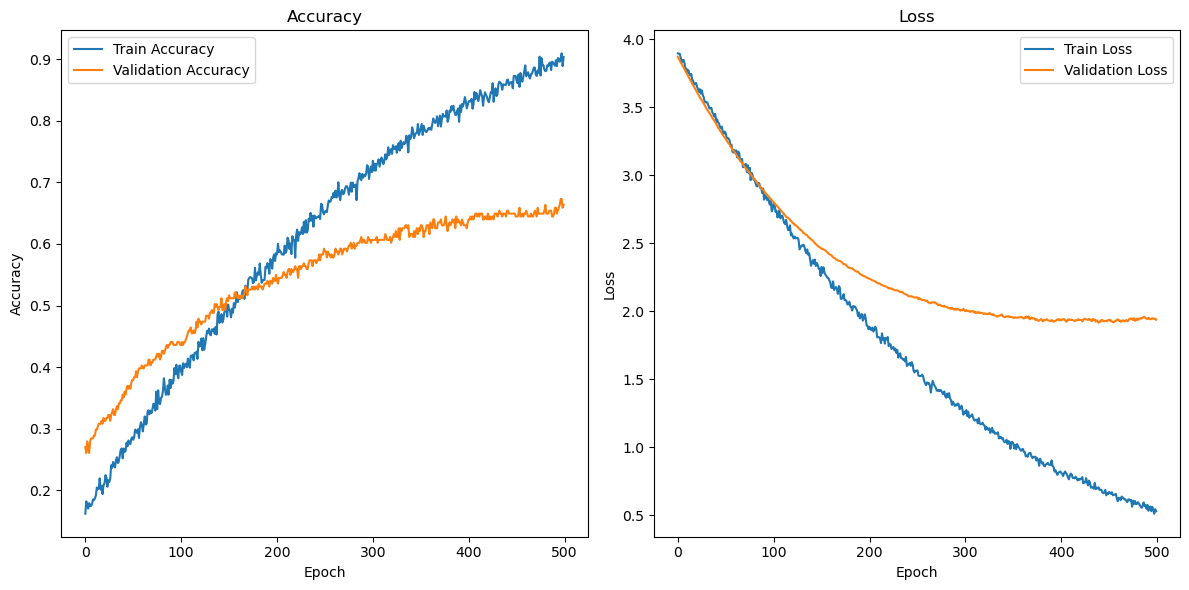

In [66]:
# Visualizing Training and Validation Metrics
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [67]:
model.save('bird_song_classifier.h5')

In [ ]:
def predict_audio(audio_file):
    with open('prediction.json', 'r') as f:
        prediction_dict = json.load(f)

    # Extract MFCC features from the audio
    mfcc_features = audio_to_mfcc(audio_file)

    # Reshape MFCC features for prediction
    mfcc_features = np.expand_dims(mfcc_features, axis=0)
    mfcc_features = np.expand_dims(mfcc_features, axis=-1)

    # Convert to TensorFlow tensor
    mfcc_tensor = tf.convert_to_tensor(mfcc_features, dtype=tf.float32)

    # Load the trained model and make a prediction
    model = tf.keras.models.load_model('bird_song_classifier_1.h5')
    prediction = model.predict(mfcc_tensor)
    predicted_class = np.argmax(prediction)
    predicted_label = prediction_dict[str(predicted_class)]
    confidence = np.max(prediction) * 100

    print(f"Predicted Class: {predicted_label}")
    print(f"Confidence: {confidence:.2f}%")

In [ ]:
audio_files = []
for root, _, files in os.walk(directory):
    for file in files:
        if file.endswith(('.mp3', '.wav')):  # Include only audio files
            audio_files.append(os.path.join(root, file))

# Ensure there are audio files in the directory
if not audio_files:
    print("No audio files found in the directory.")
else:
    # Choose a random file
    randoms = random.choice(audio_files)

    print(f"Selected File: {randoms}")

    # Load Audio File
    audio_data, sample_rate = librosa.load(path=randoms)

    # Plot the waveform
    plt.figure(figsize=(15, 5))
    librosa.display.waveshow(y=audio_data, sr=sample_rate)
    plt.title(f"Waveform of {os.path.basename(randoms)}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

    # Provide the option to play the audio
    print(f"Playing audio: {os.path.basename(randoms)}")
    display(Audio(data=randoms, autoplay=False))  # Option to play the audio


In [28]:
predict_audio(randoms)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
Predicted Class: Australian Brushturkey_sound
Confidence: 81.62%
